# Predicting COVID-19 Hotspots

#### By: Brandon Greenspan: [LinkedIn](https://https://www.linkedin.com/in/brandonlgreenspan) [Github](https://git.generalassemb.ly/bgreenspan), Jordan Weiss: [LinkedIn](https://www.linkedin.com/in/jordan-weiss-a54bb826/) [Github](https://git.generalassemb.ly/weisja4/), Aryeh Gelfand: [LinkedIn](https://www.linkedin.com/in/arigelfand/) [Github](https://git.generalassemb.ly/aryehgelfand/)

# Problem Statement

Our client wants to try to predict COVID-19 hotspots based on demographics and has asked us to build a predictive model that could predict if a county is a COVID-19 hotspot.  Since we are cautious about trying to predict an ongoing problem with many changes in real-time data, we informed that if our models don't meet a __.95 accuracy score or better__ that they should only use the model for interpretive purposes and not predictive purposes.  While the client understands the low likelihood of building a predictive model under this criteria, they gave us the budget to proceed anyway.

We defined a "COVID-19 hotspot" as a county in the contiguous US that has a rate of infected residents per capita that is higher than one standard deviation for the mean.  This actually presents an interesting situation where we already know that our baseline model will have an accuracy rate of .7625.  Due to this, we will only consider our model interpretable if we can beat the baseline accuracy.

We are viewing this as a classification problem and will look to run Logistic Regression, KNN, Support Vector Machine, Decision Tree Classifier, Bagging Classifier,Random Forest, and AdaBoost models in order to see if it's possible to predict COVID-19 hotspots based on county demographic data.

To reiterate, our goal for the model to be considered predictive is a __.95 accuracy score or better__, and our goal for the model to be considered interpretable is a __.7626 accuracy score or better__.  This is to ensure that we are held to high standards when it comes to predicting an ongoing pandemic, but also ensures that we can interpret the findings if we are performing better than average.



### Table of Contents:
- [Executive Summary](#Executive-Summary)
- [Data Collection](#Data-Collection)
- [Cleaning](#Additional-Cleaning)
- [EDA](#EDA)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
    - [Baseline Model](#Model-0:-Baseline)
    - [Logistic Regression (With All Features)](#Logistic-Regression-1)
    - [Logistic Regression Model (With Features Eliminated)](#Logistic-Regression-2)
    - [KNN](#KNN-Model)
    - [Support Vector Machine](#SVM)
    - [Decision Tree Classifier](#Decision-Tree-Classifier)
    - [Bagging Classifier](#Bagging-Classifier)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Adaboost](#Adaboost)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Coefficient Evaluation](#Coefficient-Evaluation)
- [Conclusion](#Conclusion)
- [References](#References)


# Executive Summary

Since our difficult goal is to predict COIVD-19 hotspots with 95% accuracy, we needed verifiable data that can give proper demographics for every county in the contiguous United States.  The first step was to collect expansive data from the Census Bureau, the Health Department, and covidtracking.com.  While we gathered a lot of good data, it also meant that the data required a lot of cleaning because we had over 900 columns worth of data for every single county in the US as well as territories (please see separate cleaning notebooks for cleaning code).  Since this an ongoing issue with new data coming in every minute, our cdata collection cutoff was May 8th.  Some of these categories included health resources like hospital beds, doctors, nurses, etc, all divided by county because we want to understand if certain factors could factor into a predictive model.

Since the model called for a threshold that determined a "hotspot" or "not a hotspot," we recognized that this was a classification problem from the start.  Our determined threshold was that anything greater than one standard deviation above the mean in terms of COVID-19 cases per capita would be classified as a "hotspot."  This interestingly gave us a baseline score right away of .7625 (which would be the accuracy if the model guessed that every single county was not a hotspot).

In addition to the baseline, we utilized a logistic regression twice (the first time to inform us on how to eliminate irrelevant features).  Afterwards we ran seven other classification models to see if we can meet our threshold of 95% or better for predictive purposes.  If that threshold is not reached, then we will look to interpret the model only if it can still score better than the baseline in terms of accuracy.

If we are able to interpret our model, we will look at the confusion matrix in order to investigate the predictive strength and weaknesses of the model.  Afterwards, we would look to evaluate coefficients to see if any key demographic data could help indicate COVID-19 hotspots.

Regardless of any findings, we do continue to urge that readers continue to follow CDC and WHO guidelines to help limit the spread of COVID-19.  This is expecially important if our model does not meet the predictive threshold (which is very likely) because that would show that COVID-19 can strike in any county, regardless of demographics.

Lastly, we did make an interractive Bokeh map in order to display our findings and track growth rates for COVID-19.


# Data Collection

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.base import TransformerMixin # from Mahdi

import regex as re

random_state = 11

##### Data was pulled on May 8.

In [103]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [104]:
master = master.drop(columns = 'Unnamed: 0')

Master was the result of all of our cleaned dataframes merged into one, however we found some more specific area data after the fact, which is why we read in a separate dataframe.  We will have to do a little more cleaning, but master will remain as our Master dataframe.

In [105]:
area = pd.read_csv('~/downloads/area_ready.csv')


In [106]:
area = area.drop(columns = 'Unnamed: 0')
# csv was created without index = False, so have to drop the first column
area.head()

,county,total_area,land_area,water_area
0,autauga county,1513895194,1539602155,2.570696e+07
1,baldwin county,2984648805,4117625664,1.132977e+09
2,barbour county,2241636927,2292160140,5.052321e+07
3,bibb county,1602558222,1612159622,9.601400e+06
4,blount county,1655136409,1670127873,1.499146e+07


# Additional Cleaning

Since we are still treated our master as the master, first, we're going to merge area and master and save over the master dataframe.

In [107]:
master = pd.merge(area, master, how = 'left', on=area.index)

master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


Even though we've cleaned, we still want to check our null values.

In [108]:
master.isnull().sum().sort_values()

key_0                                  0
# hosp w/diag radioisotope fac         0
other spec, tot, pc, hosp res          0
forensic path, pc, hosp ft stf         0
# stng/lt hosps,100-199 beds_y         0
                                    ... 
skilled nurs fac certified beds_x      0
# stng/lt hosps,050-099 beds_x         0
nursing home beds, st gen hosp_x       0
water_area                             1
beds_per_case                        103
Length: 853, dtype: int64

We are going to end up dropping beds per case when we set up our X & y variables because that would be technically leaking coronavirus data into our model, but for EDA purposes, it could be worth keeping around.  I'm more concerned investigating the water area null.

In [109]:
master.loc[master['water_area'].isnull()]

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
889,889,greeley county,2016057907,2016057907,NaN,greeley county,KS,20071,1200,1179,...,0.0,0.0,0.0,0.0,20,20071,18.0,0.0,0.015,inf


In [110]:
master.sort_values(by = 'case_per_pop', ascending = False)

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
2478,2478,trousdale county,290182875,296143584,5960709.0,trousdale county,TN,47169,9573,9105,...,0.0,0.0,0.0,0.0,47,47169,25.0,0.141544,0.002612,0.018450
106,106,lincoln county,1426848085,1454363491,27515406.0,lincoln county,AR,5079,13695,13622,...,0.0,0.0,0.0,0.0,5,5079,0.0,0.066229,0.000000,0.000000
1794,1794,dakota county,1327294423,1354269882,26975459.0,dakota county,NE,31043,20317,19820,...,0.0,0.0,0.0,0.0,31,31043,0.0,0.065118,0.000000,0.000000
1332,1332,nobles county,1832764854,1852080823,19315969.0,nobles county,MN,27105,21839,21450,...,0.0,0.0,0.0,0.0,27,27105,48.0,0.053894,0.002198,0.040782
2397,2397,bledsoe county,1051815457,1052644801,829344.0,bledsoe county,TN,47007,14602,14198,...,0.0,0.0,0.0,0.0,47,47007,25.0,0.041364,0.001712,0.041391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,2701,somervell county,468738044,482948955,14210911.0,somervell county,TX,48425,8743,8684,...,0.0,0.0,0.0,0.0,48,48425,16.0,0.000000,0.001830,inf
181,181,modoc county,9565374364,10225877677,660503313.0,modoc county,CA,6049,8938,8691,...,0.0,0.0,0.0,0.0,6,6049,20.0,0.000000,0.002238,inf
2695,2695,schleicher county,3394458666,3394546067,87401.0,schleicher county,TX,48413,3061,3060,...,0.0,0.0,0.0,0.0,48,48413,14.0,0.000000,0.004574,inf
2694,2694,san saba county,2932146951,2940447162,8300211.0,san saba county,TX,48411,5962,5695,...,0.0,0.0,0.0,0.0,48,48411,0.0,0.000000,0.000000,NaN


Since total area for Greeley County equals land area, I'm going to impute 0 for water area in this case.

In [111]:
master['water_area'].replace({None: 0}, inplace = True)

master['pop_density'] = master['population'] / master['total_area']

The census data we collected is in total units, but we want to see if ratios might be a better predictor of hotspots than a total.  We do want to be able to feed both into our model.  To get started, we feature engineered a column for population density.  Next we want to create a for loop to loop through the all data columns and create ratios with the population as a denominator for all of them.

In [112]:
cens = master[master.columns[8:]]
cens.drop(columns = 'county_y', inplace = True) #ran code to find this as the only object column
cens.shape

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(3108, 845)

We obviously have a lot of columns, which will possibly lead to some overfit models.  We can address this in the modeling section.

In [113]:
ratios = [] # instantiate empty list
for num in range(845): #iterates through all census columns
    ratio = cens[cens.columns[num]]/ cens['population']
    ratios.append(ratio) 
    

ratio_df = pd.DataFrame(ratios).T 
#turn list into a dataframe, need to transpose, so the values and columns line up properly
ratio_df.columns =  cens.columns

ratio_df.columns = ratio_df.columns + ' ratio'

ratio_df.head()

,population ratio,estimate!!race!!total population!!one race ratio,estimate!!race!!total population!!two or more races ratio,estimate!!race!!total population!!one race.1 ratio,estimate!!race!!total population!!one race!!white ratio,estimate!!race!!total population!!one race!!black or african american ratio,estimate!!race!!total population!!one race!!american indian and alaska native ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!chippewa tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping ratio,...,nursing facilities total beds ratio,nurse practitioners_y ratio,"advpractnurs midwve,male w/npi ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,pop_density ratio
0,1.0,0.981341,0.018659,0.981341,0.768786,0.191395,0.002880,0.001486,0.0,0.000797,...,0.0,0.0,0.0,0.000018,0.018134,0.001540,2.198855e-08,2.789593e-08,0.000023,6.605477e-10
1,1.0,0.982836,0.017164,0.982836,0.862662,0.094970,0.007314,0.001369,0.0,0.000336,...,0.0,0.0,0.0,0.000005,0.004820,0.001855,4.802750e-09,8.912795e-09,0.000009,3.350478e-10
2,1.0,0.986308,0.013692,0.986308,0.473819,0.475758,0.002793,0.001008,0.0,0.000349,...,0.0,0.0,0.0,0.000039,0.038981,0.002870,7.973384e-08,1.113265e-07,0.000054,4.461026e-10
3,1.0,0.991699,0.008301,0.991699,0.766547,0.222755,0.000355,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000044,0.044702,0.001554,8.670536e-08,6.897017e-08,0.000035,6.240023e-10
4,1.0,0.983780,0.016220,0.983780,0.955052,0.014954,0.002446,0.000347,0.0,0.000000,...,0.0,0.0,0.0,0.000017,0.017504,0.000434,1.324126e-08,7.523445e-09,0.000010,6.041798e-10


In [114]:
# ratio_df.to_csv('~/documents/population_ratios.csv')

In [115]:
master = master.join(ratio_df)

We overwrote the Master to include the ratio columns.  Data is cleaned up to where we want.

# EDA

The first thing we want to see is what the distribution of our likely target (Cases per Capita).

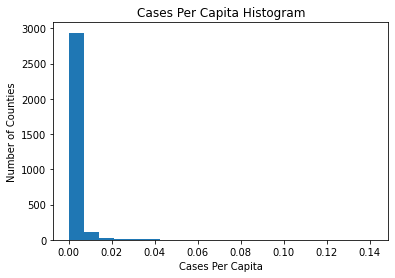

In [116]:
plt.hist(master['case_per_pop'], bins = 20)
plt.title('Cases Per Capita Histogram')
plt.xlabel('Cases Per Capita')
plt.ylabel('Number of Counties');

The target variable has a distribution that is right-skewed, which makes sense since you can't have a negative number with this feature.  Taking the log did not even out the distribution.

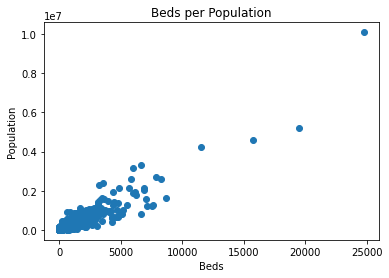

In [117]:
plt.scatter(master['beds'], master['population'])
plt.title('Beds per Population')
plt.xlabel('Beds')
plt.ylabel('Population');

We also wanted to look for any discrepancies in the amount of hospital beds given the population of a county, but found that the relationship is fairly linear with a positive correlation.  This is not surprising because one would typically expect that areas with higher populations are more likely to have a greater number of hospital beds.

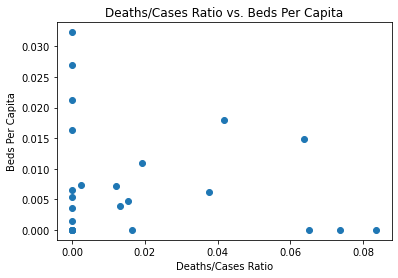

In [118]:
plt.scatter(master['deaths']/master['cases'], master['beds_per_pop'])
plt.title('Deaths/Cases Ratio vs. Beds Per Capita')
plt.xlabel('Deaths/Cases Ratio')
plt.ylabel('Beds Per Capita');


This finding was fascinating.  We wanted to explore the relationship between the likelihood of COVID-19 resulting in death compared to the amount of hospital beds per capita.  We do have many counties that have cases, but not any deaths, so that does technically throw off some of the linearity at this point in time. However, we do appear to see a slight negative correlation in this graph, which suggests that COVID-19 cases are more likely to become severe in counties that don't have a lot of hospital beds relative to their population. 

In [119]:
.95/2/2

0.2375

In [120]:
master.shape[0] * 0.2375

738.15

In [121]:
master.shape[0] - 739

2369

This informs us on how many counties will be designated as a "hotspot," as determined by counties that fall one standard deviation above the mean in terms of infections per capita.  I'm going to round up for the cutoff because the value should be larger than 738, and since you can't have .15 of a county, I will use 739 as designated hotspots.  That leaves us with 2369 that will not be considered hotspots.

In [122]:
above_std_1 = master.sort_values(by = 'case_per_pop', ascending = False).head(739)

This creates a list of counties that meet our criteria of a COVID-19 hotspot.

In [123]:
above_std_1['case_per_pop'].sort_values().head(1)

2    0.002056
Name: case_per_pop, dtype: float64

This shows our cutoff point for our cases per capita ratio.

In [124]:
below = master.sort_values(by = 'case_per_pop', ascending = False).tail(2369)

In [125]:
above_std_1['case_per_pop'] = ((above_std_1['case_per_pop'].values *0) +1).astype(int)
# converts the hotspots to a value of one for the purposes of classification
below['case_per_pop'] = ((below['case_per_pop'].values *0)).astype(int)
# converts the rest to a value of zero for the purposes of classification
master['case_per_pop'] = pd.concat([above_std_1['case_per_pop'],below['case_per_pop']])
# overwrites our cases per capita column in the master with our classifications 
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,nursing facilities total beds ratio,nurse practitioners_y ratio,"advpractnurs midwve,male w/npi ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,pop_density ratio
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.000018,0.018134,0.001540,2.198855e-08,2.789593e-08,0.000023,6.605477e-10
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.000005,0.004820,0.001855,4.802750e-09,8.912795e-09,0.000009,3.350478e-10
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.000039,0.038981,0.002870,7.973384e-08,1.113265e-07,0.000054,4.461026e-10
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.000044,0.044702,0.001554,8.670536e-08,6.897017e-08,0.000035,6.240023e-10
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.000017,0.017504,0.000434,1.324126e-08,7.523445e-09,0.000010,6.041798e-10


In [126]:
# master.to_csv('~/documents/case_per_pop_dummied_std_1.csv')

# Model Preparation

In [127]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
'''drops features that could leak in regards to COVID-19 data, numerical columns relating to id,
non-numerical columns, and remaining null columns'''
y = master['case_per_pop']
# sets target variable as cases per capita.

ss = StandardScaler()

X_ss = ss.fit_transform(X)
# For logistic regression, we will need our data scaled
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [128]:
X.shape

(3108, 1677)

Since this is a classification problem, we want to start off by building a Logistic Regression model.  Since we have 1677 columns for only 3108 rows, we're going to force the lasso penalty on the model to inform feature elimination for other models.

# Modeling

## Baseline Model

In [129]:
baseline = master['case_per_pop'].value_counts(normalize = True)[0]

Since we are using accuracy as our metric, our baseline is a score of .76227, which would occur if our model predicted an area to not be a coronavirus hotspot.  Since once standard deviation above the mean resulted in a decimal, we technically have a slightly lower baseline than initially thought.

## Logistic Regression 1

In [130]:
pipe = Pipeline([ #instantiate model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy'   
                    )

In [131]:
logreg_model = gs.fit(X_train, y_train)

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/pyt

In [132]:
logreg_train_score = logreg_model.score(X_train, y_train)

logreg_test_score = logreg_model.score(X_test, y_test)

logreg_cv = cross_val_score(logreg_model.best_estimator_, X_ss, y).mean()

In [133]:
logreg_model.best_params_

{'lr__class_weight': None,
 'lr__dual': False,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [134]:
print(f'Train Score {logreg_train_score}')
print(f'Test Score {logreg_test_score}')
print(f'Cross Val Score {logreg_cv}')

Train Score 0.8266838266838267
Test Score 0.8056628056628057
Cross Val Score 0.7770425255396596


After 90 fits for our first Logistic Regression Model, our best fit involed no class weights, no dual formation, and the liblinear solver.  For the sake of feature elimination, we forced the l1 (lasso) penalty on the model. This model was overfit because it had a  training score of .8267 and a testing score of .8057.  The testing score .8057 is still better than our baseline model's score of .76227.  Our lower cross-validation score of .777 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  Next, I want to rerun the Logistic Regression Model with the features that our lasso eliminated.  Even though I am not evaluating coefficients yet, I will have to set up a new X & y with the irrelevant features removed.

In [135]:
coefs = logreg_model.best_estimator_.steps[0][1].coef_
coef_df = pd.DataFrame(coefs).T
coef_df['coefficients'] = list(X.columns)
coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)
# gives us a dataframe of coefficients
coef_df.sort_values(by = 'coefficient')

,coefficient,feature
75,-2.393127,estimate!!sex and age!!total population!!75 to...
893,-1.402154,"estimate!!citizen, voting age population!!citi..."
927,-1.005262,unnamed: 0_y ratio
878,-0.862214,estimate!!hispanic or latino and race!!total p...
20,-0.808956,estimate!!race!!total population!!one race!!as...
...,...,...
915,0.887311,estimate!!sex and age!!total population!!16 ye...
47,1.005249,estimate!!hispanic or latino and race!!total p...
19,1.237792,estimate!!race!!total population!!one race!!as...
923,1.404032,estimate!!sex and age!!total population!!18 ye...


In [136]:
coef_df['abs'] = abs(coef_df['coefficient'])

lose_these = coef_df.loc[coef_df['abs'] < 0.0000001]

In [137]:
# lose_these.to_csv('~/documents/bad_features.csv')

Although we are not evaluating our coefficients yet, we created a list of features that added no value to our model as determined by the lasso penalty, and created a new dataframe of only the relevant features.  We will run a train, test split on this new dataframe and utilize the new dataframe for the rest of our models.

In [138]:
better_master = master.drop(columns = list(lose_these['feature'].values))

In [139]:
better_master.shape

(3108, 131)

## Logistic Regression 2

In [140]:
X = better_master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
y = better_master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [141]:
pipe = Pipeline([ #instantiate model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] 
               # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy'
                    )

In [142]:
logreg_2 = gs.fit(X_train, y_train)

logreg_2_train_score = logreg_2.score(X_train, y_train)

logreg_2_test_score = logreg_2.score(X_test, y_test)

logreg_2_cv = cross_val_score(logreg_2.best_estimator_, X_ss, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

In [143]:
logreg_2.best_params_

{'lr__class_weight': 'dict',
 'lr__dual': False,
 'lr__penalty': 'none',
 'lr__solver': 'lbfgs'}

In [144]:
print(f'Train Score {logreg_2_train_score}')
print(f'Test Score {logreg_2_test_score}')
print(f'Cross Val Score {logreg_2_cv}')


Train Score 0.8352638352638353
Test Score 0.8120978120978121
Cross Val Score 0.7863719444314998


After 270 fits for our second Logistic Regression model, our best fit involed the dict class weight, no dual formation, the lbfgs solver, and no penalty. This model was overfit because it had a  training score of .8353 and a testing score of .8121.  The testing score .8057 is still better than our baseline model's score of .76227.  Our lower cross-validation score of .7864 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  Next, we want to utilize a KNN model to see if we can improve upon our score.

# KNN Model

In [145]:
pipe = Pipeline([
    ('knn', KNeighborsClassifier())])

# set hyperparameters

pipe_params = {
    'knn__n_neighbors': [3,5,7,9,27],
    'knn__weights' : ['uniform', 'distance'], # distance gives more predictive power to closer neighbors
    'knn__p': [1,2,'p'], # allows us to test Minkowski, Euclidean, and Manhattan measurements
               
              }

gsknn = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy'
                    )

In [146]:
knn_model = gsknn.fit(X_train, y_train)

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

In [147]:
knn_test = knn_model.score(X_test, y_test)

knn_train = knn_model.score(X_train, y_train)

knn_cv = cross_val_score(knn_model.best_estimator_, X_ss, y).mean()

knn_model.best_params_

{'knn__n_neighbors': 27, 'knn__p': 2, 'knn__weights': 'distance'}

In [148]:
print(f'Train Score {knn_train}')
print(f'Test Score {knn_test}')
print(f'Cross Val Score {knn_cv}')


Train Score 1.0
Test Score 0.8043758043758044
Cross Val Score 0.7940832906162139


After 150 fits for our KNN model, our best fit involed the 27 nearest neighbors, Euclidean distance, and weighting our points by distance. This model was overfit because it had a perfect training, but a testing score of .8044.  The testing score .8044 is still better than our baseline model's score of .76227.  Our lower cross-validation score of .7941 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  Next, we want to run a Support Vector Machine to see if multidimensional grouping might allow the model to predict hotspots. 

# SVM

In [149]:
pipe = Pipeline([ #instantiate
    ('svc', SVC())])

# set hyperparameters

pipe_params = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__class_weight' : [dict, 'balanced'],
    'svc__random_state': [11],
    'svc__gamma' : ['scale', 'auto'],
    'svc__C' : [0, .5, 1],
    'svc__shrinking' : [True, False]
              }

gssvc = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy'   
                    )

In [150]:
svc_model = gssvc.fit(X_train, y_train)

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

In [151]:
svc_test = svc_model.score(X_test, y_test)

svc_train = svc_model.score(X_train, y_train)

svc_cv = cross_val_score(svc_model.best_estimator_, X_ss, y).mean()

In [152]:
svc_model.best_params_

{'svc__C': 1,
 'svc__class_weight': 'balanced',
 'svc__gamma': 'scale',
 'svc__kernel': 'poly',
 'svc__random_state': 11,
 'svc__shrinking': True}

In [153]:
print(f'Train Score {svc_test}')
print(f'Test Score {svc_train}')
print(f'Cross Val Score {svc_cv}')


Train Score 0.8043758043758044
Test Score 0.8416988416988417
Cross Val Score 0.7796091771906115


After 360 fits for our Support Vector Machine model, our best fit involed a C of 1, balanced class weights, scaled gamma, the poly kernel, and shrinking heuristics. This model was actually underfit because it had a training score of .8044, and a testing score of .8417.  The testing score .8417 is still better than our baseline model's score of .76227.  Our lower cross-validation score of .7796 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  Since our test score still doesn't meet our predictive threshold, we would like to start with a Decision Tree classifier and then optimize it with a few techniques if needed.

# Decision Tree Classifier

In [154]:
dt_pipe = Pipeline([
    ('dt' ,DecisionTreeClassifier())
])
pipe_params = {
    'dt__max_depth' : [10],
    'dt__min_samples_leaf' : [8],
    'dt__min_samples_split' : [3],
    }
dtgs = GridSearchCV(dt_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True)
                  ) # 3-fold cross-validation.
dtgs.fit(X_train,y_train)


decision_tree_test = dtgs.score(X_test, y_test)

decision_tree_train = dtgs.score(X_train, y_train)

decision_tree_cv = cross_val_score(dtgs.best_estimator_, X_ss, y).mean()

print(f'Train Score {decision_tree_train}')
print(f'Test Score {decision_tree_test}')
print(f'Cross Val Score {decision_tree_cv}')

Train Score 0.8978978978978979
Test Score 0.7606177606177607
Cross Val Score 0.747429464974551


In [155]:
dtgs.best_params_

{'dt__max_depth': 10, 'dt__min_samples_leaf': 8, 'dt__min_samples_split': 3}

For our Decision Tree model, our best fit involed a maximum depth of 10, 8 minimum samples for a leaf, a 3 minimum samples to split. This model was overfit because it had a training score of .8988, and a testing score of .7658.  The testing score .8417 is still better than our baseline model's score of .76227.  Our lower cross-validation score of .7458 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  The lower cross-validation score than the baseline might even imply tht this model wouldn't even meet our standards for interpretability.  Since our test score still doesn't meet our predictive threshold, we would like to see if a Bagging technique could boost our score.

# Bagging Classifier

In [156]:
bag_pipe = Pipeline([
    ('bag', BaggingClassifier())])
pipe_params = {
    'bag__n_estimators': [50],
    'bag__max_features': [.9]
    }
bcgs = GridSearchCV(bag_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True)) # 3-fold cross-validation.
bcgs.fit(X_train,y_train)
bagging_test = bcgs.score(X_test, y_test)

bagging_train = bcgs.score(X_train, y_train)

bagging_cv = cross_val_score(bcgs.best_estimator_, X_ss, y).mean()

print(f'Train Score {bagging_train}')
print(f'Test Score {bagging_test}')
print(f'Cross Val Score {bagging_cv}')

Train Score 0.9991419991419992
Test Score 0.8211068211068211
Cross Val Score 0.7911961311234343


In [157]:
bcgs.best_params_

{'bag__max_features': 0.9, 'bag__n_estimators': 50}

For our Bagging Classifier, our best fit involed .9 for maximum features and 50 estimators. This model was overfit because it had a training score of .9983, and a testing score of .8147.  The testing score .8147 is still better than our baseline model's score of .76227.  Our lower cross-validation score of .7941 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  Since our test score still doesn't meet our predictive threshold, we would like to see if a Random Forest Classifier could boost our score.

# Random Forest Classifier

In [158]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())])
rf_params = {
    'rf__max_depth':[5,10],
    'rf__n_estimators':[20,25,30]
}
rfgs = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5)
rfgs.fit(X_train, y_train)
rf_test = rfgs.score(X_test, y_test)

rf_train = rfgs.score(X_train, y_train)

rf_cv = cross_val_score(rfgs.best_estimator_, X_ss, y).mean()

print(f'Train Score {rf_train}')
print(f'Test Score {rf_test}')
print(f'Cross Val Score {rf_cv}')

Train Score 0.9313599313599313
Test Score 0.797940797940798
Cross Val Score 0.778965572590625


In [159]:
rfgs.best_params_

{'rf__max_depth': 10, 'rf__n_estimators': 20}

After 30 fits for our Random Forest Classifier, our best fit a maximum depth of 10 and 25 estimators. This model was overfit because it had a training score of .94, and a testing score of .8095.  The testing score .8095 is still better than our baseline model's score of .76227.  Our lower cross-validation score of .7896 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  Since our test score still doesn't meet our predictive threshold, we would like to see if the Adaboost method could boost our score.

# Adaboost

In [160]:
ada_pipe = Pipeline([
    ('ada', AdaBoostClassifier())])
ada_params = {
    'ada__n_estimators' : [250],
    'ada__learning_rate' : [1.5]
    }
adags = GridSearchCV(ada_pipe, param_grid=ada_params, cv=StratifiedKFold(shuffle=True), n_jobs=-1)
adags.fit(X_train, y_train)
ada_test = adags.score(X_test, y_test)

ada_train = adags.score(X_train, y_train)

ada_cv = cross_val_score(adags.best_estimator_, X_ss, y).mean()

print(f'Train Score {ada_train}')
print(f'Test Score {ada_test}')
print(f'Cross Val Score {ada_cv}')


Train Score 0.9253539253539254
Test Score 0.7722007722007722
Cross Val Score 0.7053077962626404


For our Adaboost, our best fit involed a learning rate of 1.5 and 250 estimators. This model was overfit because it had a training score of .9254, and a testing score of .7722.  The testing score .7722 is barely better than our baseline model's score of .76227.  Our lower cross-validation score of .7053 vs our testing score shows that our model may not perform as well against unseen data as it did against our test data.  The lower cross-validation score than the baseline might even imply tht this model wouldn't even meet our standards for interpretability.  We are confident that we will not be able to meet our 95% predictability threshold, so we do want to move on to selection for model interpretability.

# Model Selection

In [161]:
print(f'Baseline Accuracy: {baseline}')
print(f'First Logistic Regression Training Score: {logreg_train_score}')
print(f'First Logistic Regression Testing Score: {logreg_test_score}')
print(f'First Logistic Regression Cross Val Score: {logreg_cv}')
print(f'Logistic Regression (Post-Feature Elimination) Training Score: {logreg_2_train_score}')
print(f'Logistic Regression (Post-Feature Elimination) Testing Score: {logreg_2_test_score}')
print(f'Logistic Regression (Post-Feature Elimination) Cross Val Score: {logreg_2_cv}')
print(f'KNN Training Score: {knn_train}')
print(f'KNN Testing Score: {knn_test}')
print(f'KNN Val Score: {knn_cv}')
print(f'Support Vector Machine Training Score: {svc_test}')
print(f'Support Vector Machine Testing Score: {svc_train}')
print(f'Support Vector Machine Cross Val Score: {svc_cv}')
print(f'Decision Tree Training Score: {decision_tree_train}')
print(f'Decision Tree Testing Score: {decision_tree_test}')
print(f'Decision Tree Cross Val Score: {decision_tree_cv}')
print(f'Bagging Classifier Training Score: {bagging_train}')
print(f'Bagging Classifier Testing Score: {bagging_test}')
print(f'Bagging Classifier Cross Val Score: {bagging_cv}')
print(f'Random Forest Training Score: {rf_train}')
print(f'Random Forest Testing Score: {rf_test}')
print(f'Random Forest Cross Val Score: {rf_cv}')
print(f'Adaboost Training Score: {ada_train}')
print(f'Adaboost Testing Score: {ada_test}')
print(f'Adaboost Cross Val Score: {ada_cv}')


Baseline Accuracy: 0.7622265122265123
First Logistic Regression Training Score: 0.8266838266838267
First Logistic Regression Testing Score: 0.8056628056628057
First Logistic Regression Cross Val Score: 0.7770425255396596
Logistic Regression (Post-Feature Elimination) Training Score: 0.8352638352638353
Logistic Regression (Post-Feature Elimination) Testing Score: 0.8120978120978121
Logistic Regression (Post-Feature Elimination) Cross Val Score: 0.7863719444314998
KNN Training Score: 1.0
KNN Testing Score: 0.8043758043758044
KNN Val Score: 0.7940832906162139
Support Vector Machine Training Score: 0.8043758043758044
Support Vector Machine Testing Score: 0.8416988416988417
Support Vector Machine Cross Val Score: 0.7796091771906115
Decision Tree Training Score: 0.8978978978978979
Decision Tree Testing Score: 0.7606177606177607
Decision Tree Cross Val Score: 0.747429464974551
Bagging Classifier Training Score: 0.9991419991419992
Bagging Classifier Testing Score: 0.8211068211068211
Bagging Cl

We are going to select our second Logistic Regression model because a Logistic Regression model is a fairly interpretive model and the model still outperforms many of the other models we built.  Our test score of .8121 was the third best test score of all of our models and we will be able to evaluate the coefficients.

# Model Evaluation

Since we selected our model and it is a classification problem, the first thing we want to do is look at our Confusion Matrix.

## Confusion Matrix

In [162]:
logreg_preds = logreg_2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel() # From Danielle Medellin's confusion matrix setup
cm = confusion_matrix(y_test, logreg_preds)

In [163]:
cm

array([[551,  41],
       [105,  80]])

In [164]:
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Non-Hotspot Prediction', 'Hotspot Prediction']

cm_df.index = ['Actual Non-Hotspot', "Actual Hotspot"]
#This adds the appropriate row and column names for the confusion matrix

cm_df

,Non-Hotspot Prediction,Hotspot Prediction
Actual Non-Hotspot,551,41
Actual Hotspot,105,80


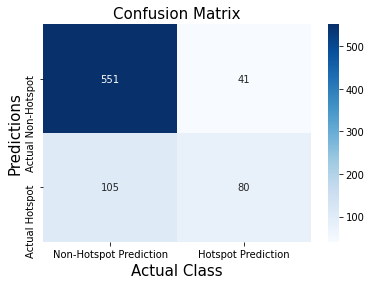

In [165]:
sns.heatmap(cm_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Confusion Matrix', size = 15)
plt.ylabel('Predictions', size = 15)
plt.xlabel('Actual Class', size = 15);

While our accuracy score does beat our baseline, the unbalanced classes of having mostly non-hotspots hurts the predictability aspect of correctly predicting COVID-19 hotspots.  Due to this, our model is mostly guessing that most areas are not hotspots, which gives 105 false positives, which would mean that this model is NOT good at predicting where there is a hotspot.  The better-than-baseline accuracy seems mostly driven by its ability to predict where there isn't a hotspot, which isn't that difficult since that is our majority class.  If we were to further fine-tune the model, we would want to significantly decrease the False Positives, which we might accomplish by either bootstrapping techniques, PCA, or adjusting our classification threshold.

Next, we do want to investigate some of our coefficients, since our model still outperformed the baseline.

## Coefficient Evaluation

In [166]:
new_coefs = logreg_2.best_estimator_.steps[0][1].coef_
# gets the coefficients
new_coef_df = pd.DataFrame(new_coefs).T
# transposes, so we can line them up correctly


new_coef_df['coefficients'] = list(X.columns)
#names a column for coefficients
new_coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)
# this is slightly confusing, but we are making sure that our features are named correctly

new_coef_df['actual_odds'] = np.exp(new_coef_df['coefficient'])
# since our coefficients are technically the log odds, we exponentiated to showcase the actual odds

In [167]:
new_coef_df.sort_values(by = 'coefficient').head()

,coefficient,feature,actual_odds
23,-5.330073,estimate!!sex and age!!total population!!75 to...,0.004844
78,-3.402592,estimate!!sex and age!!total population!!sex r...,0.033287
14,-1.952018,estimate!!race!!total population!!two or more ...,0.141987
8,-1.629154,estimate!!race!!total population!!one race!!as...,0.196095
45,-1.465498,estimate!!race!!total population!!one race!!am...,0.230963


These represent our highest negative coefficients, meaning a greater feature value in these are more likely to result in an area not being considered a hotspot.

In [168]:
new_coef_df.sort_values(by = 'coefficient').tail()

,coefficient,feature,actual_odds
6,1.490142,estimate!!race!!total population!!one race!!as...,4.437727
22,2.385746,estimate!!sex and age!!total population!!60 to...,10.867169
7,2.562487,estimate!!race!!total population!!one race!!as...,12.968027
95,2.976099,estimate!!sex and age!!total population!!18 ye...,19.611169
24,3.158591,estimate!!sex and age!!total population!!85 ye...,23.537416


These represent our highest positive coefficients, meaning a greater feature value in these are more likely to result in an area not being considered a hotspot.  For example, a one unit increase in male:female ratio for 18 and older results in a county being 19.61 times more likely to be classified as a hotspot.

An oddity we discovered is that while our strongest positive coefficient was total population of 85 and older, our strongest negative coefficient is the total population of adults 75-84.  There's a lot of news about how nursing homes are vulnerable areas, so a possible explanation for this is that those 85 and older are in nursing homes, but those from 74-85 are not in nursing homes yet, but their advanced age probably doesn't give them many opportunities to be exposed to other people who might have the virus.

In [169]:
fp_counties = y_test.loc[(y_test != 1) & (logreg_preds == 1)].index #shows me misclassified rows


fp_df = better_master.loc[master.index[fp_counties]]


fp_df['population'] = master['population'][fp_df.index].values

fp_df.sort_values(by = 'population', ascending = False)

,key_0,county,water_area,county_x,state,id,estimate!!race!!total population!!one race!!american indian and alaska native,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping,estimate!!race!!total population!!one race!!american indian and alaska native!!chippewa tribal grouping,estimate!!race!!total population!!one race!!asian!!asian indian,...,"medical specs, total, 45-54 ratio","physician assistants, prim care ratio","child psychiatry, < 35 ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,population
338,338,orange county,2.625667e+08,orange county,FL,12095,2888,169,29,19830,...,0.0,0.0,0.0,0.000009,0.009155,0.002405,8.467228e-10,1.820053e-09,0.000002,1321194
1897,1897,bernalillo county,1.691966e+07,bernalillo county,NM,35001,32867,210,175,2863,...,0.0,0.0,0.0,0.000052,0.051647,0.002923,2.242707e-09,4.313400e-09,0.000003,677692
354,354,volusia county,8.576437e+08,volusia county,FL,12127,2132,316,186,2419,...,0.0,0.0,0.0,0.000023,0.022984,0.002754,1.928896e-09,5.219153e-09,0.000005,527634
347,347,seminole county,5.432957e+08,seminole county,FL,12117,954,196,0,7578,...,0.0,0.0,0.0,0.000026,0.026626,0.000758,1.979689e-09,1.665836e-09,0.000002,455086
2291,2291,charleston county,1.139659e+09,charleston county,SC,45019,674,230,24,1196,...,0.0,0.0,0.0,0.000114,0.114056,0.005396,3.087402e-09,1.367186e-08,0.000011,394708
126,126,pulaski county,1.262301e+08,pulaski county,AR,5119,944,296,23,2378,...,0.0,0.0,0.0,0.000013,0.013010,0.010990,3.895018e-09,2.793045e-08,0.000018,393463
339,339,osceola county,4.620607e+08,osceola county,FL,12097,1526,234,0,3520,...,0.0,0.0,0.0,0.000035,0.035725,0.001855,4.831557e-09,5.476928e-09,0.000003,338619
2055,2055,lorain county,1.119495e+09,lorain county,OH,39093,1034,122,0,787,...,0.0,0.0,0.0,0.000127,0.127458,0.002892,5.708341e-09,9.428861e-09,0.000005,306713
349,349,st. lucie county,9.323545e+07,st. lucie county,FL,12111,1063,106,0,1744,...,0.0,0.0,0.0,0.000039,0.039631,0.002857,2.944771e-09,9.348310e-09,0.000010,305591
382,382,chatham county,5.097806e+08,chatham county,GA,13051,778,258,0,1962,...,0.0,0.0,0.0,0.000045,0.045466,0.005466,3.531676e-09,1.904193e-08,0.000019,287049


As we mentioned, our model is a lot better at identifying non-hotspots, so we wanted to take a deeper look at the false positives because that could indicate that certain counties might be in imminent danger of a larger outbreak.  Since this data was pulled on May 8th, we actually cross-checked this list on May 13th and identified that in only a 5 day period, Lafayette Parish and the city of Fredericksburg, VA would now meet the threshold of our given definition of a "hotspot."


In [170]:
# fp_df.to_csv('~/documents/false_positives.csv')

# Conclusion

Our chosen Logistic Regression model scored 0.8121 on accuracy, which means that while it failed to meet our goal of .95 in order to fulfill its usage as a predictive model.  However, the model did surpass the accuracy score of .7625 that allows us to interpret coefficients and further investigate potential COVID-19 hotspots.

We do want to stress that on areas of actual COVID-19 hotspots, the model did not do a good job at predicting COVID-19 hotspots.  Our clients should not make any actionable decisions based on the model other than further research into some of the possible correlated features, like the high ratio of men to women over 18 being more prevalent in COVID-19 hotspots.

In our EDA we did see that cases are more likely to result in death if a county is experiencing a shortage in hospital beds, so we urge that counties stay prepared for the worst.  Since our model does lack predictive ability, it does go to show that COVID-19 is indiscriminate as to where an outbreak might happen.  Rural and urban counties in any state are all at risk.

If we were to work to improve the predictability of the model, it would require extensive research into local polict and we would also need a way to quantify that.  Given that this is an ongoing issue, even if we somehow had all of that information quantified, it would never be "up to date."  We would advise against building any sort of predictive model to predict "hotspots," but we may consider timeseries modeling to attempt to predict potential growth (which would also have its shortcomings).  The best advice is to try to stay inside, wear a mask in public, attempt to stay 6 feet apart from each other, wash hands frequently, and only listen to accredited health experts for any advice that may deviate from those guidelines.

# References

#### Covid and Health Related Data: Data.gov, covidtracking.com, Area health resource gov resource
#### Natural Disaster Data: Columbia University Center for Disaster Preparedness 
#### Census Data: Census.gov API